# Impact of Numerical Precision on Time Series in Channel Flow at $Re_\tau=180$

This notebook discusses how to quantify the uncertainty in the temporal mean i.e. the sample mean estimator (SME) of a time series of a turbulent flow quantity. Quantifying the uncertainty in the first order moment involves finding the variance of the sample mean $\sigma^2(\hat{\mu})$. Here we use the Non-overlapping Batch Means (NOBM) estimator to find the $\sigma^2(\hat{\mu})$, because it is the most intuitive and the simplest method. In order to verify the result of the NOBM, another estimator called the Batch Means and Batch Correlations (BMBC) Estimator has also been briefly used.

To do this, we will use the [UQit](https://joss.theoj.org/papers/10.21105/joss.02871) developed by Saleh Rezaeiravesh et al.(2021). Since UQit is continuously being upgraded, it is very likely that the modules presented here would be upgraded in the future. However, we will still be using the lastest version of UQit.


In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
UQit_ts_path="UQit-ts"
sys.path.append(UQit_ts_path)
from SME import SME, SMEuncert
from NOBM import NOBM
from BMBC import BMBC
import math as mt
import plot_ts
import stats_ts


In [23]:


series_10 = np.genfromtxt('series_all_10bits')
series_11 = np.genfromtxt('series_all_11bits')
series_12 = np.genfromtxt('series_all_12bits')
series_52 = np.genfromtxt('series_all_notrunc')
#series is stored as pt_data = pt_id x_cord y_cord z_cord u v w p
#it is stored for 9 different points following
# [pt1_data_t1; pt2_data_t1;...;pt_9_data_t1; pt1_data_t2; ...; pt9_data_ti]


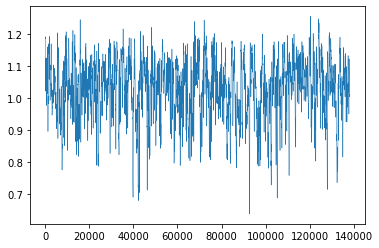

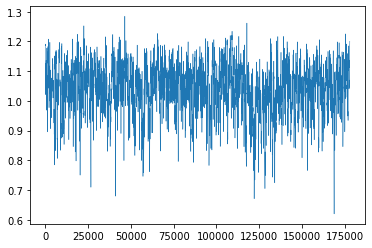

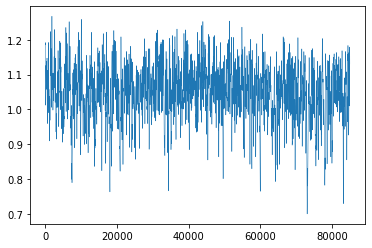

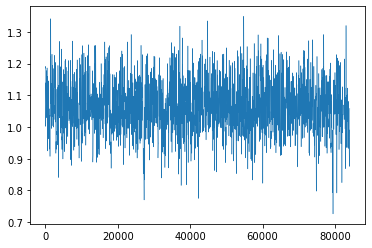

In [208]:
lvl = 4 #which lvl (element) we choose the point from
qoi = 4 #4=u 5=v 6=w 7=p
lvl_52 = series_52[lvl::9,qoi]
#lvl_52 = lvl_52[1:]-lvl_52[:-1]
plt.plot(lvl_52,linewidth=0.5)
plt.figure(2)
lvl_12 = series_12[lvl::9,qoi]
#lvl_12 = lvl_12[1:]-lvl_12[:-1]
plt.plot(lvl_12,linewidth=0.5)
plt.figure(3)
lvl_11 = series_11[lvl::9,qoi]
#lvl_11 = lvl_11[1:]-lvl_11[:-1]
plt.plot(lvl_11,linewidth=0.5)
plt.figure(4)
lvl_10 = series_10[lvl::9,qoi]
#lvl_10 = lvl_10[1:]-lvl_10[:-1]
plt.plot(lvl_10,linewidth=0.5)

Observe here that the time series appears *stationary*. This is a necessary prerequisite for all the UQ methods discussed in the UQit. Therefore the initial transient must be removed before using NOBM, or BMBC or ARM estimators.

The NOBM is a way of transforming the correlated turbulent time series into a series of uncorrelated batch means for which the Central Limit Theorem can be applied. 

NOBM in UQit requires 3 things as input:
t = time indices or sample numbers as 1D array
f = 1D array of the time series data
M = batch size.

The NOBM gives incorrect estimates of uncertainty if the batch size is chosen small enough that the series of batch means is still autocorrelated. Therefore, as a first check, we plot the **lag-1 sample autocorrelation** $\rho_1$ between the batch means series for different batch sizes and find out the optimal batch size at which the first order autocorrelation is zero. It is also needed to have a batch size that would lead to statistically significant number of batch means. The lag-1 autocorrelation is given by

$\hat{\rho}_1 = \dfrac{\sum\limits_{j=1}^{K-1}(\bar{u}_j - \hat{\mu})(\bar{u}_{j+1} - \hat{\mu})}{\sum\limits_{j=1}^{K}(\bar{u}_j - \hat{\mu})^2}, 
$ 

where the $\bar{u}_j$ are the batch means and $K$ is the total number of batches, given a batch size $M$.

$\bar{u}_{j} = \dfrac{1}{M}\sum\limits_{i=jM+1}^{(j+1)M} u_i, \hspace{1cm} \text{for j}= 0,1,2,\cdots, K.$ 

Let us find the optimal batch size by plotting $\rho_1$ vs batch sizes.

In [155]:
fx = lvl_52
t=np.arange(len(fx))*3e-3
print(len(fx))

138281


In [170]:

batchsizes = np.arange(10, 30000, 300)

rho1_NOBM = np.zeros(len(batchsizes))
var_NOBM = np.zeros(len(batchsizes))
trueMean = np.mean(fx)
sme_nobm = SME(t, fx, {'verbose':False,'conv':True})

for j in range(len(batchsizes)):
    M = batchsizes[j]
    K1, tnobm, bmeans = NOBM.batchGen(t, fx, M)
    bmeans_mod = bmeans - trueMean
    s1 = np.sum(bmeans_mod[:-1] * bmeans_mod[1:])
    s0 = np.sum(bmeans_mod * bmeans_mod)
    rho1_NOBM[j] = np.divide(s1,s0)
    out_nobm = SMEuncert(sme_nobm,{'method':'NOBM','batchSize':M}).estim
    var_NOBM[j] = out_nobm['fSME_var'][-1]
    if (j%10 == 0): print(j)



0


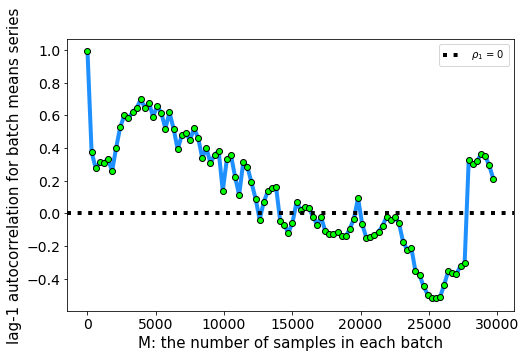

In [171]:
plt.figure(figsize=(8, 5))
plt.plot(batchsizes, rho1_NOBM,'dodgerblue', linewidth=4, marker='o', markeredgecolor='black', markerfacecolor='lime')
plt.axhline(0, color='k', linestyle=':', lw=4, label=r'$\rho_1$ = 0')
plt.xlabel('M: the number of samples in each batch', fontsize=15)
plt.ylabel('lag-1 autocorrelation for batch means series', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.show()

The batch size best suited is that which covers around 3000 samples, (i.e. at M = 3000) Because at this M value, we have zero correlation between adjacent batches, satisfying the condition for CLT application and it is at the start of $\rho_1=0$, leading to adequate $K$. For values of M larger than 10000, there are big fluctuations because of inadequate number of batches.

Now with this batch size, the NOBM will estimate the **variance in the sample mean** $\hat{\sigma}^2(\hat{\mu})$


$\hat{\sigma}^2 = \dfrac{1}{(K-1)}\bigg[\dfrac{1}{K}\sum\limits_{j=1}^K \bar{u}_j^2 - \hat{\mu}^2\bigg]$,



With the help of the tool **plotter_signal_estimates** from UQit, it is possible to see the evolution of the sample mean and the evolution of the uncertainty for the underlying time series.

138281
...... Plotting UQ estimates for the signal
...... Interpolating 92 samples to a series of 138281 samples.
       using linear method.
...... Interpolating 138281 samples to a series of 138281 samples.
       using linear method.


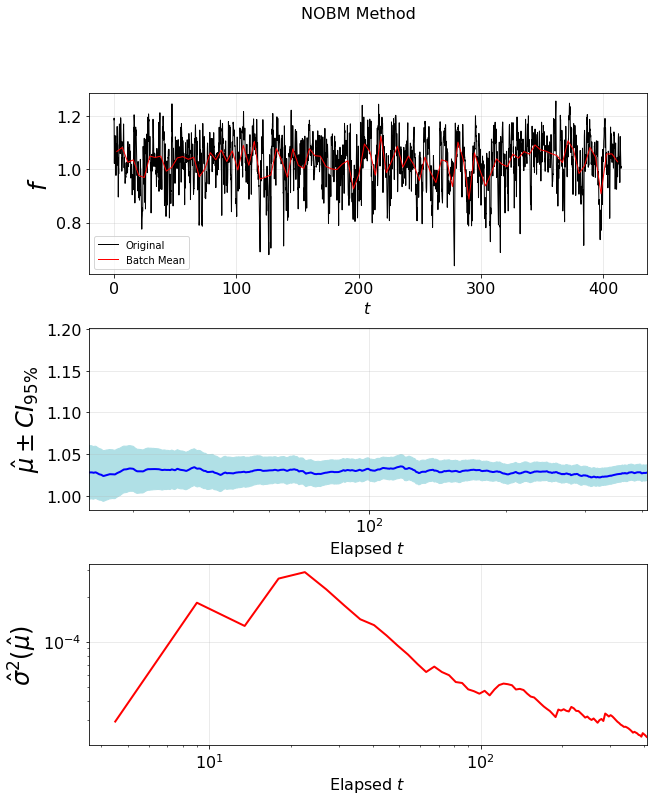

AttributeError: module 'plot_ts' has no attribute 'savefig'

In [209]:
fx = lvl_52
t=np.arange(len(fx))*3e-3
print(len(fx))
Mb = 1500
sme_n = SME(t, fx, {'verbose':False,'conv':True})
varEstim = SMEuncert(sme_n,{'method':'NOBM','batchSize':Mb}).estim
pltOpts = {'title':'NOBM Method'}
output = plot_ts.plotter_signal_estimates(varEstim, pltOpts)
plot_ts.savefig('whate')


84086
...... Plotting UQ estimates for the signal
...... Interpolating 168 samples to a series of 84086 samples.
       using linear method.
...... Interpolating 84086 samples to a series of 84086 samples.
       using linear method.


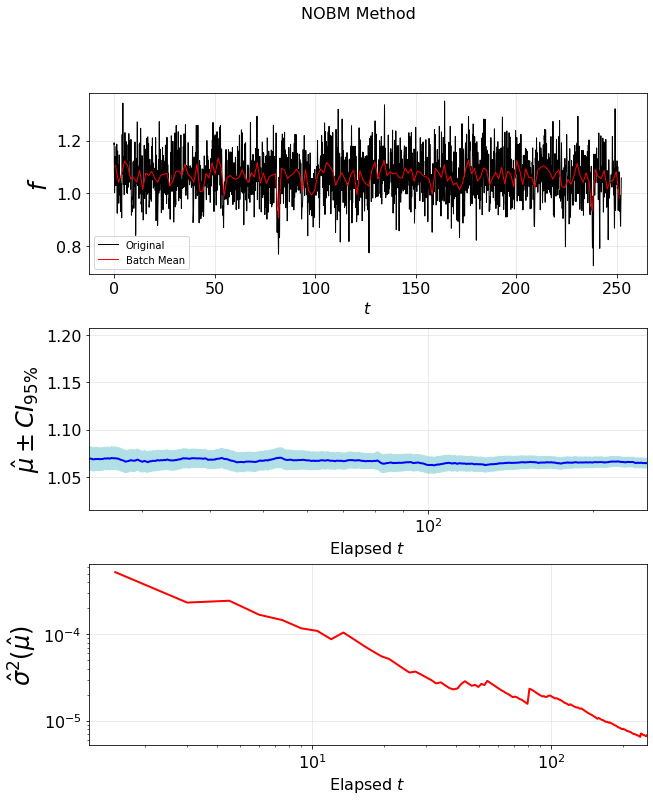

In [195]:
fx = lvl_10
t=np.arange(len(fx))*3e-3
print(len(fx))
Mb = 500
sme_n = SME(t, fx, {'verbose':False,'conv':True})
varEstim = SMEuncert(sme_n,{'method':'NOBM','batchSize':Mb}).estim
output = plot_ts.plotter_signal_estimates(varEstim, pltOpts)

84086
...... Plotting UQ estimates for the signal
...... Interpolating 42 samples to a series of 84086 samples.
       using linear method.
...... Interpolating 84086 samples to a series of 84086 samples.
       using linear method.


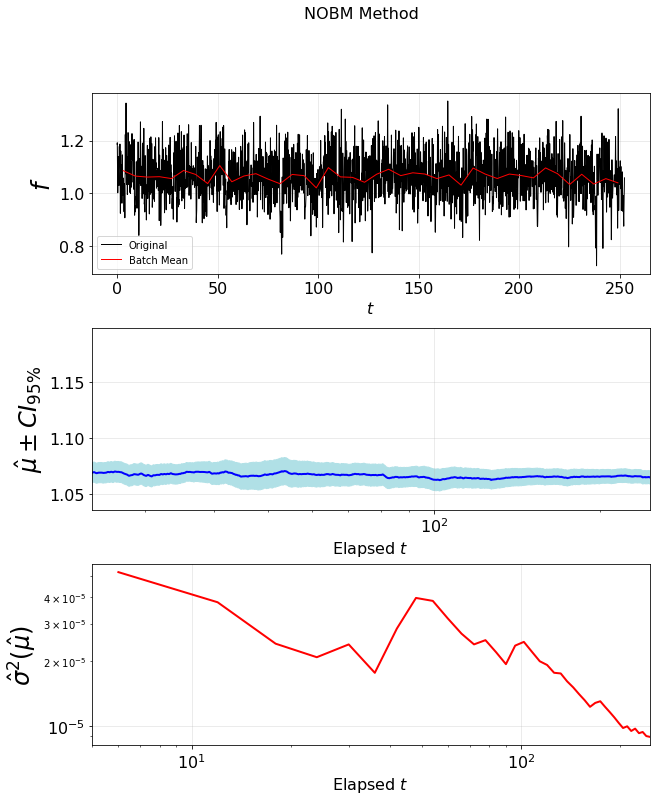

In [185]:
fx = lvl_10
t=np.arange(len(fx))*3e-3
print(len(fx))
Mb = 2000
sme_n = SME(t, fx, {'verbose':False,'conv':True})
varEstim = SMEuncert(sme_n,{'method':'NOBM','batchSize':Mb}).estim
output = plot_ts.plotter_signal_estimates(varEstim, pltOpts)

84995
...... Plotting UQ estimates for the signal
...... Interpolating 42 samples to a series of 84995 samples.
       using linear method.
...... Interpolating 84995 samples to a series of 84995 samples.
       using linear method.


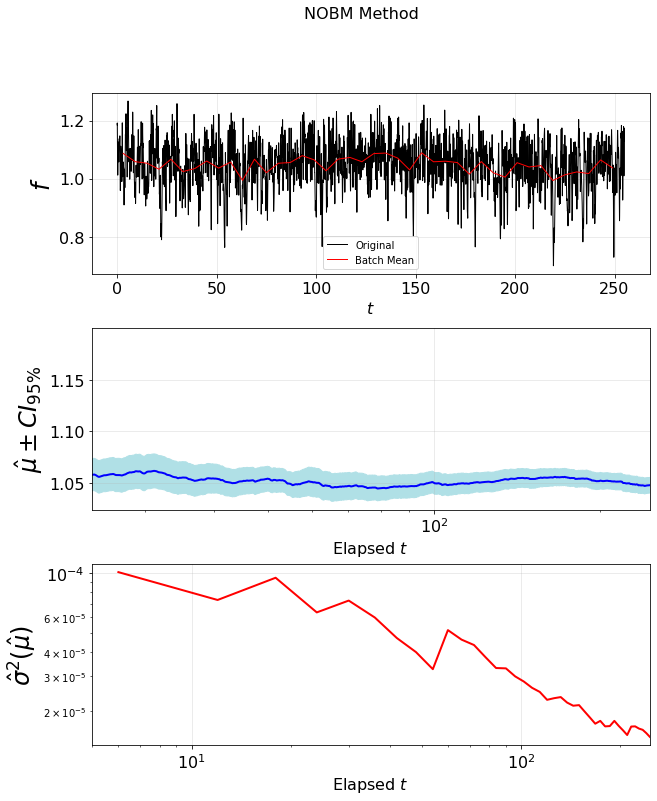

In [186]:
fx = lvl_11
t=np.arange(len(fx))*3e-3
print(len(fx))
Mb = 2000
sme_n = SME(t, fx, {'verbose':False,'conv':True})
varEstim = SMEuncert(sme_n,{'method':'NOBM','batchSize':Mb}).estim
output = plot_ts.plotter_signal_estimates(varEstim, pltOpts)

177907
...... Plotting UQ estimates for the signal
...... Interpolating 88 samples to a series of 177907 samples.
       using linear method.
...... Interpolating 177907 samples to a series of 177907 samples.
       using linear method.


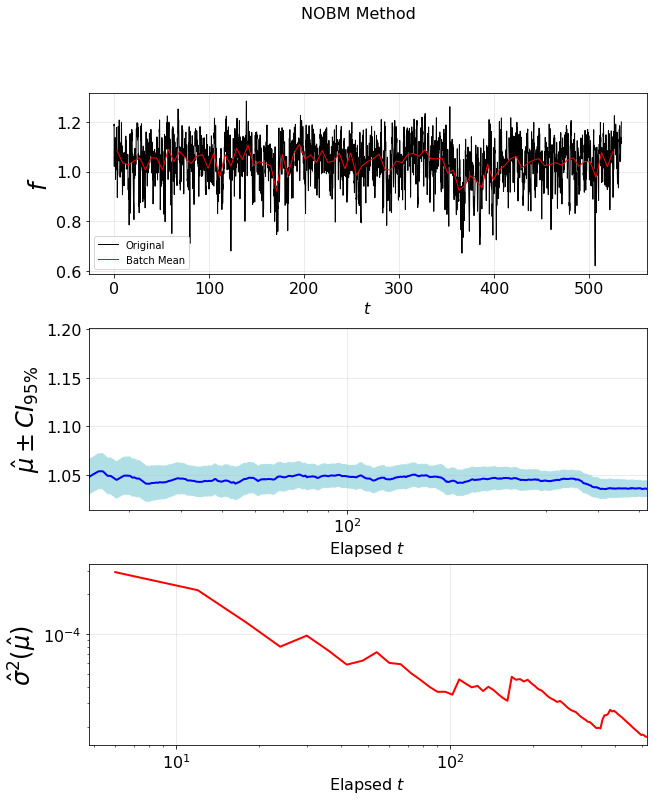

In [187]:
fx = lvl_12
t=np.arange(len(fx))*3e-3
print(len(fx))
Mb = 2000
sme_n = SME(t, fx, {'verbose':False,'conv':True})
varEstim = SMEuncert(sme_n,{'method':'NOBM','batchSize':Mb}).estim
output = plot_ts.plotter_signal_estimates(varEstim, pltOpts)

Observe how the uncertainty in the evolution of the sample mean reduces with time. This is an expected behaviour. The uncertainty in time average needs to reduce as more samples in time are gathered. 

(Elapsed t is just the time count for the cumulative sample mean here)

# 2a. Comparison with BMBC:
 How do we know if the given estimate of the uncertainty i.e. $\hat{\sigma}^2(\hat{\mu})$ is correct?? 
 We desire the estimator to be unbiased and consistent. The consistency of the estimator has been proved. Now, in order to ensure that these low values of variance predicted by the estimator are truly correct, we can compare with another estimator. If the variance estimates by 2 estimators are same, then everything we've followed in the procedure is correct. For this check, we use the BMBC estimator and find out the variance

The BMBC estimator has been developed by Russo and Luchini(2017). We observed that for its accurate functioning the batch size needs to be chosen from the highly correlated region of the batch means series. 

In [179]:
Mbmbc = 3000 ## much smaller batch size than the NOBM!!


varEs_bmbc = SMEuncert(sme_n,{'method':'BMBC','batchSize':Mbmbc}).estim


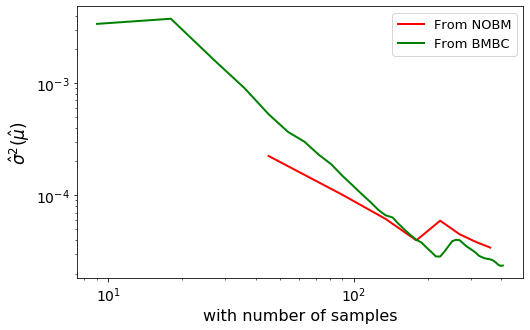

In [180]:
plt.figure(figsize=(8,5))
plt.loglog(varEstim['tElapsedEstim'][1:], varEstim['fSME_var'][1:], 'r', linewidth=2, label="From NOBM")
plt.loglog(varEs_bmbc['tElapsedEstim'][1:], varEs_bmbc['fSME_var'][1:], 'g', linewidth=2, label="From BMBC")
plt.xlabel(r'with number of samples', fontsize=16)
plt.ylabel(r'$\hat{\sigma}^2(\hat{\mu})$', fontsize=17)
plt.legend(loc='best', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Observe that beyond a certain Elapsed t, the variance estimates by the two estimators coincide. This proves that we're using (both) the estimators correctly. The variance $\sigma^2(\hat{\mu})$ estimated by both estimators for the whole series can be checked as well.


In [81]:
print('NOBM: ',varEstim['fSME_var'][-1])
print('BMBC:' , varEs_bmbc['fSME_var'][-1])

NOBM:  1.5782251036106442e-05
BMBC: 1.5767342097860263e-05


# **3. Computing the $95\%$ confidence intervals for $u(y,t)$ by looping over all wall-normal locations**

Thus the uncertainty at all wall normal locations requires only a for loop over the y locations. 

In [21]:
fy_SME =[]   #sample mean
cbi_SME =[]  #95% CI of the sample mean
M2 = 3000

for i in range(1,Ny):
#(0) Training data
    fy = u[i, :] # for each wall normal location, extract the time series into the variable fy
    fy_SME.append(np.mean(fy))
#(2) Estimate the variance of SME using obm method
    sme_y = SME(t, fy, {'verbose':False,'conv':True})
    outvar  = SMEuncert(sme_y,{'method':'NOBM','batchSize':M2}).estim
    varnobm = outvar['fSME_var'][-1]  # last value is the final variance of all samples. This is the correct one
    cbi_SME.append(1.96*mt.sqrt(abs(varnobm)))
    
ciSME = np.asarray(cbi_SME)
u_means = np.asarray(fy_SME)



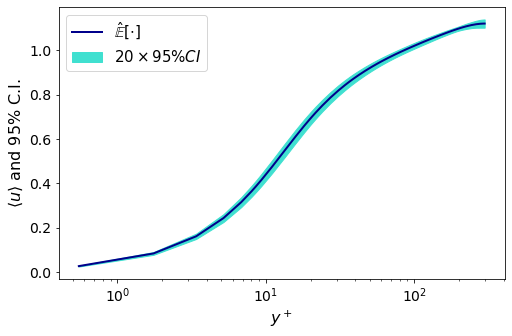

In [22]:
plt.figure(figsize=(8, 5))
plt.semilogx(yplus[1:], u_means, 'darkblue', linewidth = '2.', label=r'$\hat{\mathbb{E}}[\cdot]$')
ax = plt.gca()
ax.fill_between(yplus[1:], u_means - (20*ciSME), u_means + (20*ciSME), color='turquoise', label=r'$ 20\times95\% CI$')
plt.legend(loc='best',fontsize=15)
plt.xlabel(r'$y^+$',fontsize=16)
plt.ylabel(r"$\langle u \rangle$ and $95\%$ C.I.",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()